# CS-UY 3943 - Introduction of Data Science
## Week 10: Classification III

Please edit the cell below to add your name, NetID, assigned group, and group members for this assignment. **Complete this section before proceeding to the assignment questions.**

Name: Lenny Remache
NetID: ljr381
Group (Letter): E
Group Member 1: ai1138
Group Member 2: fs1593
***

This assignment will continue where we left off from our last session. Again, we will be analyzing data generated by particle physicists to test whether machine learning can help classify certain particle decay experiments to identify the presence of a Higgs Boson. Today the goal will be to choose a model based on cross-validation. 

For this assignment, you will need an implementation of the cross validation function from our previous meeting. Therefore, if you were unable to finish this part of the assignment last week, be sure to complete your function implementation before starting the remainder of today's exercise.

### Model Selection using the One Standard Error Rule

The performance metric computed by k-fold cross-validation can be summarized to compare the regularization hyperparameter values for the Support Vector Machine classifier (SVC). One such summary value can be obtained by computing the mean of the performance metric under consideration (_AUC_ in this case) across cross validation iterations. It is tempting to simply choose the parameter $C$ which has the highest mean AUC value. However, such a choice fails to consider the uncertainty (or variance) of the results across cross validation iterations. A larger variance indicates that we should feel less certain about the mean performance metric under consideration. A model built with such a parameter choice may not generalize very well to unseen data. Therefore, considering more than just the mean performance metric score can help identify the "best" parameter choice given the options under consideration.

A well-known heuristic named the "one standard error rule" can be used to evaluate cross-validation results. Stated simply, the rule says to indentify the best performing model based on the metric under consideration. Then find the parameter choice which results in the *least* complex model with an estimated performance that is **within 1 standard error** of the best performing model. This parameter choice identifies a model with a performance that is not significantly different than the best performing model while prioritizing model simplicity.

In the case of AUC, where we are attempting to maximize our performance metric, the heuristic directs us to choose the least complex model with a performance value at most **1 standard error less** than the best performing model. If the performance metric was an error/loss where the goal is to minimize the value of the performance metric, the heuristic would direct us to choose the least complex model with a performance value at most 1 standard error more than the best performing model.

To focus this question on creating a one standard error plot and interpreting the results, assume that (in general) **larger values of $C$ produce a more complex SVC.**

In [3]:
import random
import pandas as pd
import numpy as np
from sklearn import svm, linear_model, metrics
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [4]:
mv_df = pd.DataFrame()
mv2_df = pd.DataFrame()

def clean_boson_data(infile_name,mv_df):
    df = pd.read_csv(infile_name, sep = ",")
    df["Y"] = df["Label"].map({"b":0,"s":1})
    df = df.drop(columns=['Label'])
    for (columnName,columnData) in df[df.columns[df.columns != 'EventId']].iteritems():
        booldf = df[columnName].isin([-999])
        mv_df[columnName + "_mv"] = booldf.map({True:0, False:1})
    df = df.replace(-999,np.nan)
    mean = df.mean()
    std = df.std()
    df = df.set_index("EventId")
    for (columnName,columnData)  in df[df.columns[df.columns != 'Y' ]].iteritems():
        df[columnName] = df[columnName].replace(np.nan,df[columnName].mean())
        df[columnName] = df[columnName] - df[columnName].mean()
        df[columnName] = df[columnName] / df[columnName].std()
    return df

testing_df = clean_boson_data("boson_testing_cut.csv",mv_df)
training_df = clean_boson_data("boson_training_cut.csv",mv2_df)

In [5]:
def cross_val_svm(dataset, label_name, k, cs):
    dataset = dataset.sample(frac = 1)
    sizeFold = len(dataset)//k
    aucs = {}
    for elem in cs:
        aucs[elem] = []
    for i in range(k):
        split_1 = dataset.iloc[0:sizeFold*i]
        split_2 = dataset.iloc[sizeFold*(i+1):-1]
        data_train = pd.concat([split_1, split_2])
        data_test = dataset.iloc[sizeFold*i: sizeFold*(i+1)]
        x_test = data_test.drop(columns = [label_name])
        y_test = data_test[label_name]
        for c in cs:
            x_train = data_train.drop(columns = [label_name])
            y_train = data_train[label_name]
            svc = svm.SVC(C=c,kernel = "linear").fit(x_train,y_train)
            y_pred = svc.decision_function(x_test)
            auc = roc_auc_score(y_test,y_pred)
            aucs[c].append(auc)
    return aucs

Using your custom cross-validation function, perform the following:
1. Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1) with 10-fold cross validation.
1.	Call `aucs = cross_val_svm(data_train, 'Y', 10, cs)`
1.	For each `c` in `cs`, calculate the mean AUC value ($\overline{AUC}$) and the standard error (SE) of the mean AUC ($SE_{\overline{AUC}}$)
1.	Compute the value: $\max(\overline{AUC}-SE_{\overline{AUC}})$ across all values of `c`.
1.	Generate a plot with the following:
    1.	$\log_{10}(c)$ on the x-axis
    1.	1 series with $\overline{AUC}$ for each `c` (use ".--" as color pattern)
    1.	a band between $\overline{AUC}+SE_{\overline{AUC}}$ and $\overline{AUC}-SE_{\overline{AUC}}$ for each `c` (see [fill_between](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html), use `0.1` for `alpha`)
    1.	a horizontal reference line for $\max(\overline{AUC}-SE_{\overline{AUC}})$ (use 'r' as color pattern)

**Then answer these questions:** Which value of $C$ does the plot indicate should be chosen? Did the model parameters selected beat the out-of-the-box model for SVM? 

An example of the expected layout of the plot is shown below
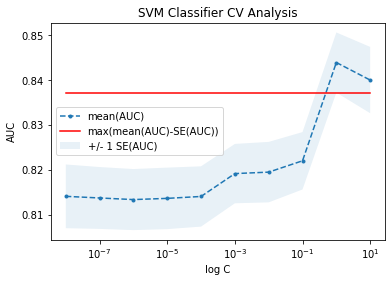

In [34]:
#cs = random.choices(range(10**(-8), 10**1), 10)
cs = np.array([10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(1)])
aucs = cross_val_svm(training_df, 'Y', 10, cs)

aucs = pd.DataFrame(aucs)

In [35]:
print(pd.DataFrame(aucs))

   1.000000e-08  1.000000e-07  1.000000e-06  1.000000e-05  1.000000e-04  \
0      0.725060      0.725060      0.730935      0.741487      0.741847   
1      0.654965      0.654965      0.655949      0.675416      0.675306   
2      0.719923      0.719923      0.720828      0.720262      0.726594   
3      0.700924      0.700924      0.704005      0.707086      0.706096   
4      0.604794      0.604794      0.605240      0.615050      0.617280   
5      0.737901      0.737901      0.737901      0.774084      0.771257   
6      0.704396      0.704396      0.706365      0.715989      0.717738   
7      0.683099      0.683099      0.682989      0.681668      0.683869   
8      0.727023      0.727023      0.732892      0.791334      0.795330   
9      0.620754      0.620754      0.624625      0.666459      0.671329   

   1.000000e-03  1.000000e-02  1.000000e-01  1.000000e+00  1.000000e+01  
0      0.742806      0.766067      0.784772      0.785612      0.785971  
1      0.676619      0.701

In [37]:
auc_mean = aucs.mean(axis=1)

print(auc_mean)

0    0.752962
1    0.685630
2    0.735357
3    0.711862
4    0.639275
5    0.771291
6    0.718755
7    0.696864
8    0.785627
9    0.675062
dtype: float64


In [25]:
auc_means = pd.DataFrame(auc_means,columns = cs)
auc_means.head()

ValueError: If using all scalar values, you must pass an index

<p>
<span style="color:blue">
Provide answer here
</span>
</p>